# Example Code for Using the Continuous Trigger Code
------------------------
Import the need packages to run the test notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tescal.io import loadstanfordfile
from tescal.trigger import rand_sections_wrapper, optimumfilt_wrapper, rand_sections
from tescal.detcal import autocuts
from tescal.utils import calc_psd, foldpsd
from time import time

% matplotlib inline

Let's get a list of the included data that we will study. We'll use two Stanford DAQ .mat files.

In [2]:
fpath = sorted(glob("test_data_*.mat"))

We'll load one of the files, in order to take a look at the properties. Note the `convtoamps` optional argument. This is by default set to 1024, which is the current value that the Stanford data should be divided by in order to convert to Amps.

In [3]:
traces, times, fs, ttl = loadstanfordfile(fpath[0], convtoamps=1024)

Now, let's use the rand_sections_wrapper function to find `n` random traces of the specified length `l`. These random traces are taken from the two datasets such that they can be anywhere in each file, but must not overlap with any other random trace.

In [4]:
rand_sections_wrapper?

In [5]:
start = time()
n, l = 100, 125000
t, res = rand_sections_wrapper(fpath, n, l, datashape=traces.shape[::2])
print(time()-start)

24.157987356185913


With the data loaded, we can sum the two channels and use `autocuts` to quickly choose the good traces. We can then estimate the PSD.

In [6]:
pt = res.sum(axis=1)
cut = autocuts(pt, fs=fs)
f, psd = calc_psd(pt[cut], fs=fs, folded_over=False)

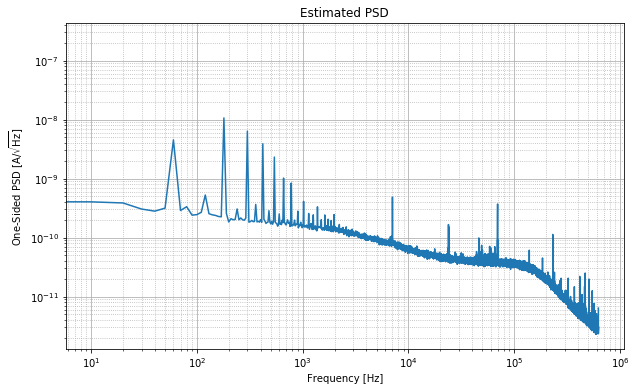

In [7]:
f_fold, psd_fold = foldpsd(psd, fs=fs)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(f_fold, np.sqrt(psd_fold))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("One-Sided PSD [A/$\sqrt{\mathrm{Hz}}$]");
ax.grid()
ax.grid(which="minor", linestyle="dotted")
ax.set_title("Estimated PSD");

Now, we want to start detecting events via the pulse/ttl triggers. We can look at the documentation to see what the inputs/outputs will be.

In [8]:
optimumfilt_wrapper?

Let's make a dummy pulse template that is close to what we've historically seen. A more detailed pulse template analysis would need to be done in practice, but we can do this for a quick test.

In [9]:
tracelength = 125000
# Dummy pulse template
nbin = len(psd)
ind_trigger = round(nbin/2)
tt = 1.0/fs *(np.arange(1,nbin+1)-ind_trigger)
lgc_b0 = tt < 0.0

# pulse shape
tau_rise = 20.0e-6
tau_fall = 80.0e-6
testtemplate = np.exp(-tt/tau_fall)-np.exp(-tt/tau_rise)
testtemplate[lgc_b0] = 0.0
testtemplate = testtemplate/max(testtemplate)

Since we have a TTL channel in this data, we want to also set a TTL template, so that we can detect the TTL triggers. These look like short square wave pulses.

In [10]:
nbinttl = 64
ttltime = 8e-6 # length of ttl pulse in seconds
ttllen = int(ttltime*fs)
ind_trigger = ttllen//2

ttltemplate = np.zeros(nbinttl)
ttltemplate[ind_trigger:ind_trigger+ttllen] = 1

Let's set the thresholds. The pulse threshold is set to 10$\sigma$ of the energy resolution, in order to ensure we get pulses. The TTL threshold is set to 0.8, which was done by hand. This was set to a value that is lower than the true amplitude of the TTL pulse (which, in this case, is 1.0), such that the TTL pulses will be detected as when the estimated TTL amplitude is greater than the set threshold.

In [11]:
thresh = 10
ttlthresh = 0.8

We can now run the continuous trigger on the two data files.

In [12]:
start = time()
pt, pa, tt, ta, ts, types = optimumfilt_wrapper(fpath, testtemplate, psd, tracelength, thresh, positivepulses=True,
                                                trigtemplate=ttltemplate, trigthresh=ttlthresh, iotype="stanford")
print(time()-start)

64.26961731910706


Note the many outputs! In order, we have the pulse times, the pulse amplitudes, the TTL trigger times, the TTL trigger amplitudes, the detected traces, and the trigger types. See the documentation for further explanation of each value. Each of these outputs is an array of length = the number of triggered events.

Let's look at the first detected event to see a triggered event.

In [13]:
ii = 0
print(types[ii])

[False  True  True]


Note that the trigger types array for this event says that both the pulse and TTL were triggered. The code has been written such that the traces are centered on the TTL trigger (i.e. the TTL is the primary trigger). However, we save the time and amplitude of the pulse as well. Thus, to compare the pulse and the template, we need to take this time difference into account.

Let's look at the result, zoomed into the center of the trace to see the pulse.

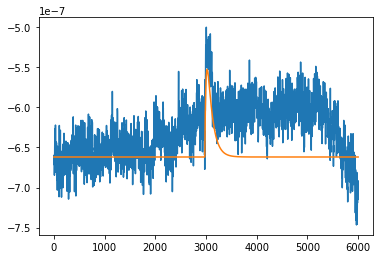

In [14]:
plt.plot(ts[ii].sum(axis=0)[ts.shape[-1]//2-3000:ts.shape[-1]//2+3000])

temp = testtemplate*pa[ii] + ts[ii].sum(axis=0).mean()
temp = np.roll(temp, int((pt[ii]-tt[ii])*fs))

plt.plot(temp[ts.shape[-1]//2-3000:ts.shape[-1]//2+3000] );

And we see a pulse!